# [18] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [18.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import neighbors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

C:\Users\raj52\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

In [3]:
print (filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [18.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
ORDER BY ProductID,UserId,Time
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150519,0006641040,A12HY5OZ2QNK4N,Elizabeth H. Roessner,0,0,5,1256774400,It's a great book!,I've always loved chicken soup and rice. My la...
1,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,4,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci..."
2,150512,0006641040,A1DJXZA5V5FFVA,A. Conway,0,0,5,1338249600,Must have.,I set aside at least an hour each day to read ...
3,150497,0006641040,A1HKYQOFC8ZZCH,"Maria Apolloni ""lanarossa""",2,2,1,1334707200,"The story is great, the softcover book is disa...",I give five stars to the Maurice Sendak story....
4,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,5,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
5,150522,0006641040,A1S3C5OFU508P3,Charles Ashbacher,0,0,4,1219536000,Children will find it entertaining and a gener...,This book contains a collection of twelve shor...
6,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
7,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...
8,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
9,150514,0006641040,A2ONB6ZA292PA,Rosalind Matzner,0,0,5,1313884800,Chicken soup with Rice,It's a great book with adorable illustrations....


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## 18.1.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [12]:
#nltk.download('stopwords')
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'just', 'didn', 'wasn', 'did', "didn't", 'into', 'shouldn', 're', 'that', 'over', 'our', "should've", 'will', "hasn't", "that'll", 'itself', 'mustn', 'her', 'because', 'whom', "you've", 'herself', 'some', 'of', 'its', 'we', 'once', 'out', 'mightn', 'not', 'y', 'can', 've', 'hasn', 'more', "hadn't", 'him', 'too', 'wouldn', 'those', 'themselves', 'is', "isn't", 'they', 'had', 'all', 'my', 'yourself', 'or', "shouldn't", 'this', 'which', 's', 'as', 'same', 'there', "it's", 'through', "mustn't", 'd', 'i', 'theirs', 'for', 'do', 'an', 'after', 'now', 'you', 'won', 'yours', 'about', 'above', 'between', 'has', 'ourselves', 'll', 'than', "you're", 'aren', 'am', 'only', 'under', 'doing', 'during', 'ours', 'yourselves', 'where', 'them', 'hers', 'on', "shan't", 'me', 'here', 'haven', 'himself', 'he', 'she', 'nor', 'before', 'why', 'other', 'these', 'his', 'are', 'was', 'have', 'most', 'don', 'in', 'from', 'again', 'who', 'ain', "wasn't", 'against', "doesn't", "weren't", 'each', "aren't", 'to', 'b

In [13]:
#removing stop words and html tags
#listing all words from potive and negative reviews

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [14]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [18]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [2]:
con = sqlite3.connect('final.sqlite') 

final = pd.read_sql_query(""" SELECT * FROM Reviews """, con) 

In [3]:
#Sampling 20K Data-Points of 364K Data-Points

final=final.sort_values('Time')
df_sampled=final[:20000]

print("The number of negative points and positive points are ",
      df_sampled[df_sampled['Score']=='negative'].shape[0]
     ,"&",df_sampled[df_sampled['Score']=='positive'].shape[0])

The number of negative points and positive points are  2174 & 17826


## [18.1.4] Split Dataset into Train and Test

In [4]:
# split the data set into train and test

from sklearn import model_selection as ms
y=df_sampled['Score']
dw_train,dw_test,y_train,y_test=ms.train_test_split(df_sampled, y, test_size=0.3, random_state=0)
print(dw_train.shape,dw_test.shape)

(14000, 12) (6000, 12)


# [18.2] Bag of Words (BoW)

In [7]:
#Build The Vocabulary
#Vectorize train and test data
count_vect = CountVectorizer() #in scikit-learn
d_train=count_vect.fit_transform(dw_train['CleanedText'].values)

In [8]:
print("the type of count vectorizer ",type(d_train))
print("the shape of train-text BOW vectorizer ",d_train.get_shape())

d_test = count_vect.transform(dw_test['CleanedText'].values)
print("the shape of test-text BOW vectorizer ",d_test.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train-text BOW vectorizer  (14000, 15632)
the shape of test-text BOW vectorizer  (6000, 15632)


## [18.2.1] Bag Of Words with Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [24]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [5]:
#bi-gram, tri-gram and n-gram
#building the vocabulary
#removing stop words like "not" should be avoided before building n-grams
count_vect_bg = CountVectorizer(ngram_range=(1,2))
d_train_bg=count_vect_bg.fit_transform(dw_train['CleanedText'].values)

In [6]:
#Vectorize train and test data
print("the type of count vectorizer ",type(d_train_bg))
print("the shape of train-text BOW vectorizer ",d_train_bg.get_shape())

d_test_bg = count_vect_bg.transform(dw_test['CleanedText'].values)
print("the shape of test-text BOW vectorizer ",d_test_bg.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train-text BOW vectorizer  (14000, 281647)
the shape of test-text BOW vectorizer  (6000, 281647)


## [18.2.2] ConVert Sparce Matrix To Dense Using TruncatedSVD

In [14]:
svd = TruncatedSVD(n_components=2000, random_state=0)
#without using bigram
d_train_dense=svd.fit_transform(d_train)

In [15]:
print (svd.explained_variance_ratio_)
print (svd.explained_variance_ratio_.cumsum())

[4.11878231e-02 3.67717226e-02 1.55181718e-02 ... 3.41136910e-05
 3.40277144e-05 3.37737473e-05]
[0.04118782 0.07795955 0.09347772 ... 0.95253415 0.95256818 0.95260195]


Variance of 95% is retained with dimension equal to 2000.

In [17]:
d_test_dense=svd.transform(d_test)

In [7]:
dv_train=d_train_bg[:20000]
svd_m = TruncatedSVD(n_components=600, random_state=0)

In [8]:
#using bigrams
d_train_bg_dense=svd_m.fit_transform(dv_train)
print (svd_m.explained_variance_ratio_)
print (svd_m.explained_variance_ratio_.cumsum())

[0.02564133 0.02293013 0.00983019 0.00894277 0.00766993 0.00716409
 0.00644842 0.00573583 0.00547404 0.00532305 0.00488414 0.00485649
 0.00462404 0.00444995 0.00424964 0.00412082 0.00399722 0.00390175
 0.00384269 0.00381227 0.00380386 0.00367986 0.00360575 0.00347496
 0.00333333 0.00323307 0.00313258 0.00310785 0.00303052 0.00292175
 0.0028494  0.00278125 0.00271867 0.00265883 0.0026426  0.002597
 0.00253491 0.00250211 0.00249323 0.00240082 0.0023847  0.00233707
 0.00227341 0.00223848 0.00216391 0.00212977 0.00207618 0.00205909
 0.00203872 0.00201981 0.00198213 0.00196083 0.00192426 0.00192047
 0.00189897 0.00187733 0.00186874 0.00181756 0.00179617 0.00179322
 0.00176946 0.00174563 0.00173096 0.00171551 0.00169917 0.00166985
 0.00164035 0.00163066 0.00159706 0.00158341 0.00157973 0.00156238
 0.00153813 0.00153115 0.00150045 0.00148555 0.00147451 0.00147081
 0.00145211 0.00144532 0.00143701 0.00143012 0.00140463 0.00139415
 0.00138985 0.00137259 0.00134319 0.001338   0.00133026 0.001319

 0.55851492 0.55874612 0.55897659 0.55920561 0.55943382 0.55966174]


In [9]:
d_test_bg_dense=svd_m.transform(d_test_bg)

## [18.2.3] KNN (Brute-Force)


The optimal number of neighbors is 11.


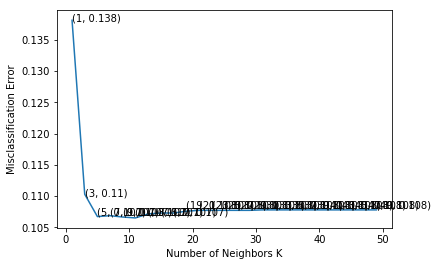

the misclassification error for each k value is :  [0.138 0.11  0.107 0.107 0.107 0.107 0.107 0.107 0.107 0.108 0.108 0.108
 0.108 0.108 0.108 0.108 0.108 0.108 0.108 0.108 0.108 0.108 0.108 0.108
 0.108]


In [29]:
from sklearn.model_selection import cross_val_score as cval_score
from sklearn.neighbors import KNeighborsClassifier

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn_brute = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cval_score(knn_brute, d_train,y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [12]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
knn_optimal.fit(d_train,y_train)
#for train error
y_true, y_pred = y_train, knn_optimal.predict(d_train)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("Train error is %.3f" %((fp+fn)/140))

#for test error
y_true, y_pred = y_test, knn_optimal.predict(d_test)
cm=confusion_matrix(y_true, y_pred)

Train error is 10.571



The value of TPR is 0.999
The value of TNR is 0.012
The value of FPR is 0.988
The value of FNR is 0.001

Test error is 11.000


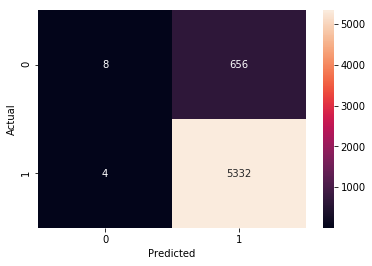

In [44]:
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='Actual')
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()

print("Test error is %.3f" %((fp+fn)/60))


### Using Bigrams


The optimal number of neighbors is 9.


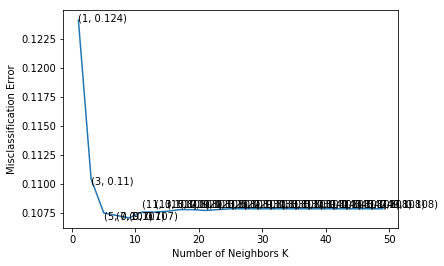

the misclassification error for each k value is :  [0.124 0.11  0.107 0.107 0.107 0.108 0.108 0.108 0.108 0.108 0.108 0.108
 0.108 0.108 0.108 0.108 0.108 0.108 0.108 0.108 0.108 0.108 0.108 0.108
 0.108]


In [32]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn_brute = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cval_score(knn_brute, d_train_bg,y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [48]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
knn_optimal.fit(d_train_bg,y_train)
#for train error
y_true, y_pred = y_train, knn_optimal.predict(d_train_bg)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("Train error is %.3f" %((fp+fn)/140))

#for test error
y_true, y_pred = y_test, knn_optimal.predict(d_test_bg)
cm=confusion_matrix(y_true, y_pred)

Train error is 10.657



The value of TPR is 1.000
The value of TNR is 0.011
The value of FPR is 0.989
The value of FNR is 0.000

Test error is 10.967


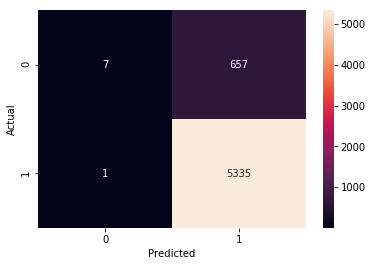

In [50]:
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='Actual')
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()
print("Test error is %.3f" %((fp+fn)/60))

## [18.2.4] KNN (KD-Tree)

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
49

The optimal number of neighbors is 7.


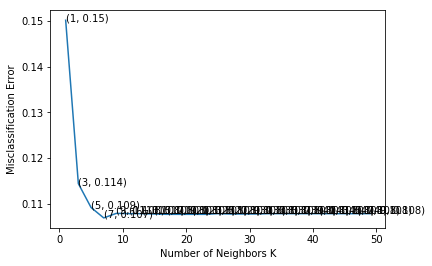

the misclassification error for each k value is :  [0.15  0.114 0.109 0.107 0.108 0.108 0.108 0.108 0.108 0.108 0.108 0.108
 0.108 0.108 0.108 0.108 0.108 0.108 0.108 0.108 0.108 0.108 0.108 0.108
 0.108]


In [14]:
from sklearn.model_selection import cross_val_score as cval_score
from sklearn.neighbors import KNeighborsClassifier


# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 2-fold cross validation
for k in neighbors:
    knn_kd = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    print(k)
    scores_kd = cval_score(knn_kd, d_train_dense,y_train, cv=2, scoring='accuracy')
    cv_scores.append(scores_kd.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [18]:
knn_kd_optimal = KNeighborsClassifier(n_neighbors=7,algorithm='kd_tree')
knn_kd_optimal.fit(d_train_dense,y_train)
#for train error
y_true, y_pred = y_train, knn_kd_optimal.predict(d_train_dense)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("Train error is %.3f" %((fp+fn)/140))
#for test error
y_true, y_pred = y_test, knn_kd_optimal.predict(d_test_dense)
cm=confusion_matrix(y_true, y_pred)

Train error is 10.036



The value of TPR is 0.996
The value of TNR is 0.039
The value of FPR is 0.961
The value of FNR is 0.004

Test error is 10.967


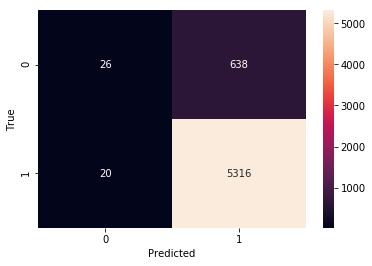

In [19]:
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='True')
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()
print("Test error is %.3f" %((fp+fn)/60))

### Using Bigrams

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
49

The optimal number of neighbors is 9.


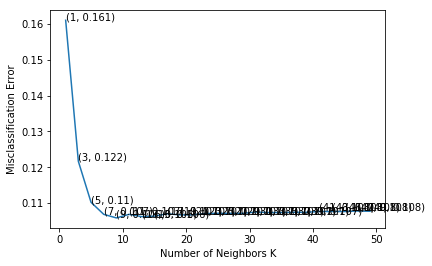

the misclassification error for each k value is :  [0.161 0.122 0.11  0.107 0.106 0.107 0.106 0.106 0.107 0.107 0.107 0.107
 0.107 0.107 0.107 0.107 0.107 0.107 0.107 0.107 0.108 0.108 0.108 0.108
 0.108]


In [11]:
from sklearn.model_selection import cross_val_score as cval_score
from sklearn.neighbors import KNeighborsClassifier

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    print(k)
    knn_kd = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores_kd = cval_score(knn_kd, d_train_bg_dense,y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores_kd.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [12]:
knn_kd_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn_kd_optimal.fit(d_train_bg_dense,y_train)
#for train error
y_true, y_pred = y_train, knn_kd_optimal.predict(d_train_bg_dense)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("Train error is %.3f" %((fp+fn)/140))
#for test error
y_true, y_pred = y_test, knn_kd_optimal.predict(d_test_bg_dense)
cm=confusion_matrix(y_true, y_pred)

Train error is 9.736



The value of TPR is 0.995
The value of TNR is 0.056
The value of FPR is 0.944
The value of FNR is 0.005

Test error is 10.900


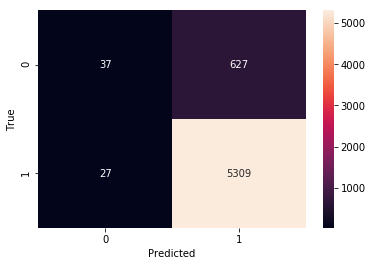

In [13]:
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='True')
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()
print("Test error is %.3f" %((fp+fn)/60))

**Observation :**
The accuracy is almost same when we are using brute-foce KNN and KD-Tree KNN in both the cases i.e. while using bigrams & n-grams and when we are not using bigrams & n-grams.

# [18.3] TF-IDF

In [5]:
#Build The Vocabulary
tf_idf_vect = TfidfVectorizer()
d_train=tf_idf_vect.fit_transform(dw_train['CleanedText'].values)

In [6]:
#Vectorize train and test data
print("the type of count vectorizer ",type(d_train))
print("the shape of train-text BOW vectorizer ",d_train.get_shape())

d_test = tf_idf_vect.transform(dw_test['CleanedText'].values)
print("the shape of test-text BOW vectorizer ",d_test.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train-text BOW vectorizer  (14000, 15632)
the shape of test-text BOW vectorizer  (6000, 15632)


### Using Bigrams ###

In [5]:
##Build The Vocabulary using bi-grams and ngrams
tf_idf_vect_ng = TfidfVectorizer(ngram_range=(1,2))
d_train_ng=tf_idf_vect_ng.fit_transform(dw_train['CleanedText'].values)

In [6]:
#Vectorize train and test data

print("the type of count vectorizer ",type(d_train_ng))
print("the shape of train-text BOW vectorizer ",d_train_ng.get_shape())

d_test_ng = tf_idf_vect_ng.transform(dw_test['CleanedText'].values)
print("the shape of test-text BOW vectorizer ",d_train_ng.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train-text BOW vectorizer  (14000, 281647)
the shape of test-text BOW vectorizer  (14000, 281647)


## [18.3.1] ConVert Sparce Matrix To Dense Using TruncatedSVD

In [9]:
svd = TruncatedSVD(n_components=4000, random_state=0)
#without using bigram
d_train_dense=svd.fit_transform(d_train)

In [10]:
print (svd.explained_variance_ratio_)
print (svd.explained_variance_ratio_.cumsum())

[3.34695510e-03 1.05892243e-02 7.52687142e-03 ... 2.71112219e-05
 2.70664296e-05 2.69988762e-05]
[0.00334696 0.01393618 0.02146305 ... 0.93827056 0.93829763 0.93832463]


Variance of 94% is retained with dimension equal to 4000.

In [11]:
d_test_dense=svd.transform(d_test)

In [7]:
dv_train=d_train_ng[:20000]
svd_m = TruncatedSVD(n_components=700, random_state=0)

In [8]:
#using bigrams
d_train_ng_dense=svd_m.fit_transform(dv_train)
print (svd_m.explained_variance_ratio_)
print (svd_m.explained_variance_ratio_.cumsum())

[0.00107144 0.00337399 0.00231914 0.00162754 0.00149142 0.00142097
 0.00129976 0.00121034 0.00116515 0.00114128 0.00110561 0.0010996
 0.0010388  0.00099458 0.00098735 0.00097283 0.00096465 0.00094027
 0.00091868 0.00090752 0.00088248 0.00086171 0.00083861 0.00083053
 0.00080008 0.00078783 0.00077507 0.00076554 0.00076495 0.00076079
 0.00074925 0.00073854 0.0007333  0.00072899 0.00071422 0.00070221
 0.00070068 0.00069347 0.0006893  0.00068609 0.00067511 0.00067336
 0.00066162 0.00065829 0.00064978 0.00064089 0.00063908 0.00063506
 0.00062912 0.00062505 0.00062134 0.00061354 0.00060767 0.0006024
 0.00059908 0.00059656 0.000589   0.00058459 0.000582   0.00057678
 0.00057441 0.00057133 0.00056664 0.0005647  0.00055795 0.00055586
 0.00055322 0.00055153 0.00054719 0.00054447 0.00053775 0.00053486
 0.00053379 0.00053072 0.00052757 0.0005255  0.00052299 0.00051904
 0.00051732 0.00051295 0.00051053 0.00050905 0.00050645 0.00050164
 0.00050104 0.00049803 0.00049489 0.00049278 0.0004913  0.000489

 0.2218246  0.22196993 0.2221152  0.22225976]


In [9]:
d_test_ng_dense=svd_m.transform(d_test_ng)

## [18.3.4] KNN (Brute-Force)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [05:37<00:00, 13.99s/it]



The optimal number of neighbors is 7.


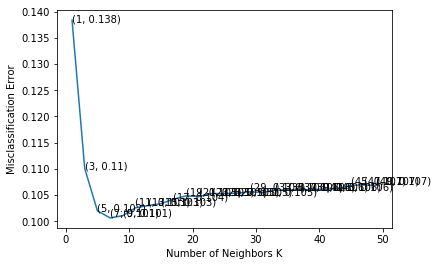

the misclassification error for each k value is :  [0.138 0.11  0.102 0.101 0.101 0.103 0.103 0.103 0.104 0.105 0.105 0.105
 0.105 0.105 0.106 0.105 0.106 0.106 0.106 0.106 0.106 0.106 0.107 0.107
 0.107]


In [7]:
from sklearn.model_selection import cross_val_score as cval_score
from sklearn.neighbors import KNeighborsClassifier

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in tqdm(neighbors):
    knn_brute = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cval_score(knn_brute, d_train,y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [13]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
knn_optimal.fit(d_train,y_train)
#for train error
y_true, y_pred = y_train, knn_optimal.predict(d_train)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("Train error is %.3f" %((fp+fn)/140))
#for test error
y_true, y_pred = y_test, knn_optimal.predict(d_test)
cm=confusion_matrix(y_true, y_pred)

Train error is 9.007



The value of TPR is 0.995
The value of TNR is 0.119
The value of FPR is 0.881
The value of FNR is 0.005

Test error is 10.183


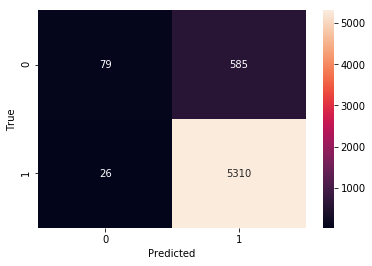

In [14]:
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='True')
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()
print("Test error is %.3f" %((fp+fn)/60))

### Using Bigrams


The optimal number of neighbors is 7.


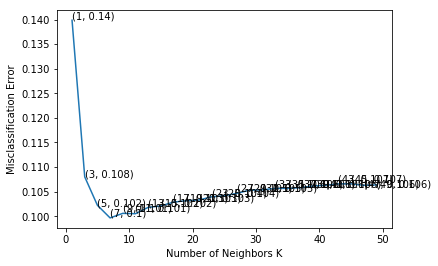

the misclassification error for each k value is :  [0.14  0.108 0.102 0.1   0.101 0.101 0.102 0.102 0.103 0.103 0.103 0.104
 0.104 0.105 0.105 0.105 0.106 0.106 0.106 0.106 0.106 0.107 0.107 0.106
 0.106]


In [15]:
from sklearn.model_selection import cross_val_score as cval_score
from sklearn.neighbors import KNeighborsClassifier

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn_brute = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cval_score(knn_brute, d_train_ng,y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [16]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
knn_optimal.fit(d_train_ng,y_train)
#for train error
y_true, y_pred = y_train, knn_optimal.predict(d_train_ng)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("Train error is %.3f" %((fp+fn)/140))
#for test error
y_true, y_pred = y_test, knn_optimal.predict(d_test_ng)
cm=confusion_matrix(y_true, y_pred)

Train error is 8.857



The value of TPR is 0.994
The value of TNR is 0.119
The value of FPR is 0.881
The value of FNR is 0.006

Test error is 10.283


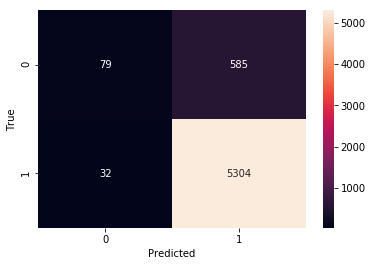

In [17]:
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='True')
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()
print("Test error is %.3f" %((fp+fn)/60))

## [18.3.5] KNN (KD-Tree)

100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [6:03:45<00:00, 861.37s/it]



The optimal number of neighbors is 7.


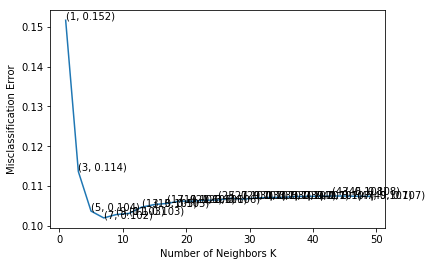

the misclassification error for each k value is :  [0.152 0.114 0.104 0.102 0.103 0.103 0.105 0.105 0.106 0.106 0.106 0.106
 0.107 0.107 0.107 0.107 0.107 0.107 0.107 0.107 0.107 0.108 0.108 0.107
 0.107]


In [12]:
from sklearn.model_selection import cross_val_score as cval_score
from sklearn.neighbors import KNeighborsClassifier

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in tqdm(neighbors):
    knn_kd = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores_kd = cval_score(knn_kd, d_train_dense,y_train, cv=2, scoring='accuracy')
    cv_scores.append(scores_kd.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [13]:
knn_kd_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn_kd_optimal.fit(d_train_dense,y_train)
#for train error
y_true, y_pred = y_train, knn_kd_optimal.predict(d_train_dense)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("Train error is %.3f" %((fp+fn)/140))
#for test error
y_true, y_pred = y_test, knn_kd_optimal.predict(d_test_dense)
cm=confusion_matrix(y_true, y_pred)

Train error is 9.171



The value of TPR is 0.995
The value of TNR is 0.104
The value of FPR is 0.896
The value of FNR is 0.005

Test error is 10.400


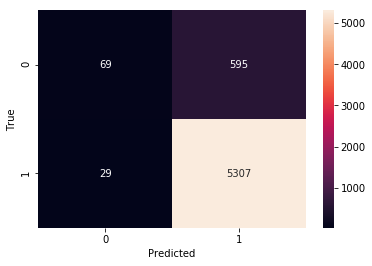

In [14]:
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='True')
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()
print("Test error is %.3f" %((fp+fn)/60))

### Using Bigrams

100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [1:10:00<00:00, 163.68s/it]



The optimal number of neighbors is 23.


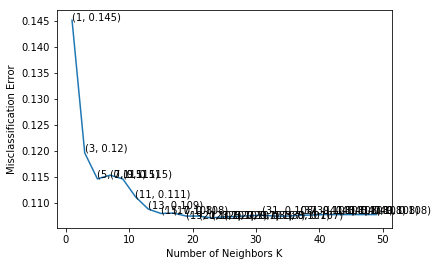

the misclassification error for each k value is :  [0.145 0.12  0.115 0.115 0.115 0.111 0.109 0.108 0.108 0.107 0.107 0.107
 0.107 0.107 0.107 0.108 0.107 0.107 0.108 0.108 0.108 0.108 0.108 0.108
 0.108]


In [10]:
from sklearn.model_selection import cross_val_score as cval_score
from sklearn.neighbors import KNeighborsClassifier

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in tqdm(neighbors):
    knn_kd = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores_kd = cval_score(knn_kd, d_train_ng_dense,y_train, cv=2, scoring='accuracy')
    cv_scores.append(scores_kd.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [11]:
knn_kd_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn_kd_optimal.fit(d_train_ng_dense,y_train)
#for train error
y_true, y_pred = y_train, knn_kd_optimal.predict(d_train_ng_dense)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("Train error is %.3f" %((fp+fn)/140))
#for test error
y_true, y_pred = y_test, knn_kd_optimal.predict(d_test_ng_dense)
cm=confusion_matrix(y_true, y_pred)

Train error is 10.621



The value of TPR is 1.000
The value of TNR is 0.014
The value of FPR is 0.986
The value of FNR is 0.000

Test error is 10.933


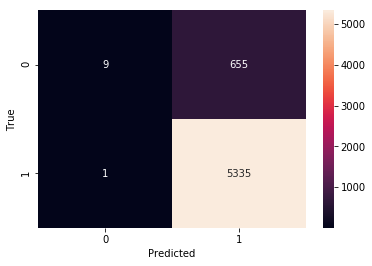

In [12]:
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='True')
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()
print("Test error is %.3f" %((fp+fn)/60))

# [18.4] Word2Vec

In [26]:
i=0
train_list=[]
test_list=[]
for sent in dw_train['CleanedText'].values:
    train_list.append(sent.split())
for sent in dw_test['CleanedText'].values:
    test_list.append(sent.split())

In [29]:
from gensim.models import Word2Vec
w2v_model=Word2Vec(train_list,min_count=5,size=50, workers=4)

In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5352
sample words  ['grew', 'loma', 'linda', 'product', 'excit', 'see', 'avail', 'amazon', 'bad', 'news', 'low', 'fat', 'big', 'frank', 'way', 'differ', 'normal', 'one', 'newli', 'vegetarian', 'girlfriend', 'tri', 'embarrass', 'werent', 'near', 'good', 'actual', 'made', 'littl', 'sick', 'theyr', 'dens', 'strang', 'stick', 'linkett', 'find', 'somewher', 'els', 'dont', 'think', 'peppermint', 'tea', 'help', 'upset', 'stomach', 'sleep', 'love', 'order', 'sever', 'time']


## [18.4.1] Average W2V

In [37]:
# compute average word2vec for each review in train
d_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in train_list: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    d_train.append(sent_vec)
print(len(d_train))
print(len(d_train[0]))

14000
50


In [38]:
# compute average word2vec for each review in test
d_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in test_list: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    d_test.append(sent_vec)
print(len(d_test))
print(len(d_test[0]))

6000
50


## [18.4.2] KNN (Brute-Force)


The optimal number of neighbors is 19.


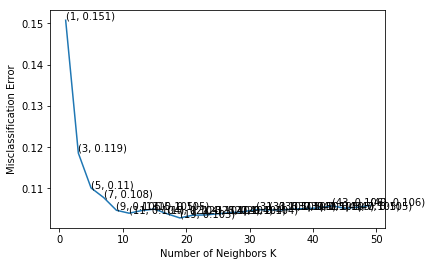

the misclassification error for each k value is :  [0.151 0.119 0.11  0.108 0.105 0.104 0.105 0.105 0.104 0.103 0.104 0.104
 0.104 0.104 0.104 0.105 0.105 0.105 0.105 0.105 0.105 0.106 0.105 0.105
 0.106]


In [40]:
from sklearn.model_selection import cross_val_score as cval_score
from sklearn.neighbors import KNeighborsClassifier

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn_brute = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cval_score(knn_brute, d_train,y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [41]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn_optimal.fit(d_train,y_train)
#for train error
y_true, y_pred = y_train, knn_optimal.predict(d_train)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("Train error is %.3f" %((fp+fn)/140))
#for test error
y_true, y_pred = y_test, knn_optimal.predict(d_test)
cm=confusion_matrix(y_true, y_pred)

Train error is 10.143



The value of TPR is 0.996
The value of TNR is 0.060
The value of FPR is 0.940
The value of FNR is 0.004

Test error is 10.783


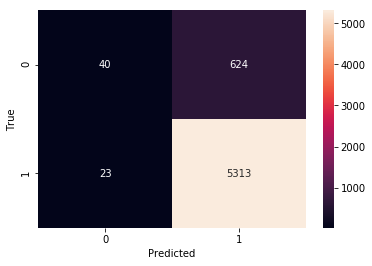

In [42]:
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='True')
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()
print("Test error is %.3f" %((fp+fn)/60))

## [18.4.3] KNN (KD-Tree)


The optimal number of neighbors is 19.


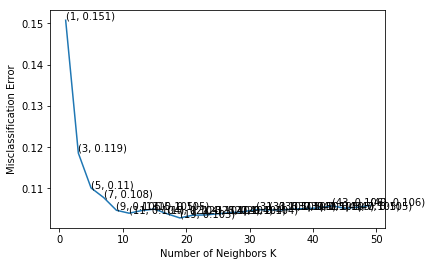

the misclassification error for each k value is :  [0.151 0.119 0.11  0.108 0.105 0.104 0.105 0.105 0.104 0.103 0.104 0.104
 0.104 0.104 0.104 0.105 0.105 0.105 0.105 0.105 0.105 0.106 0.105 0.105
 0.106]


In [43]:
from sklearn.model_selection import cross_val_score as cval_score
from sklearn.neighbors import KNeighborsClassifier

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn_kd = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores_kd = cval_score(knn_kd, d_train,y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores_kd.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [44]:
knn_kd_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn_kd_optimal.fit(d_train,y_train)
#for train error
y_true, y_pred = y_train, knn_optimal.predict(d_train)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("Train error is %.3f" %((fp+fn)/140))
#for test error
y_true, y_pred = y_test, knn_kd_optimal.predict(d_test)
cm=confusion_matrix(y_true, y_pred)

Train error is 10.143



The value of TPR is 0.996
The value of TNR is 0.060
The value of FPR is 0.940
The value of FNR is 0.004

Test error is 10.783


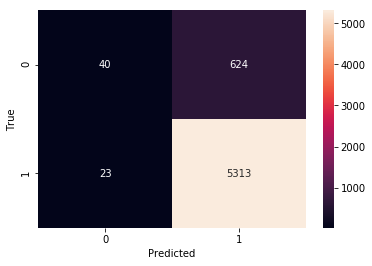

In [45]:
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='True')
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()
print("Test error is %.3f" %((fp+fn)/60))

## [18.4.5] TF-IDF W2V

In [47]:
from tqdm import tqdm
# TF-IDF weighted Word2Vec
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))
# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names() 
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

d_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
#for train dataset
for sent in tqdm(train_list):
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    d_train.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 14000/14000 [00:34<00:00, 407.31it/s]


In [48]:
#for train dataset
d_test=[]
for sent in tqdm(test_list):
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    d_test.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:14<00:00, 400.14it/s]


## [18.4.7] KNN (Brute-Force)


The optimal number of neighbors is 21.


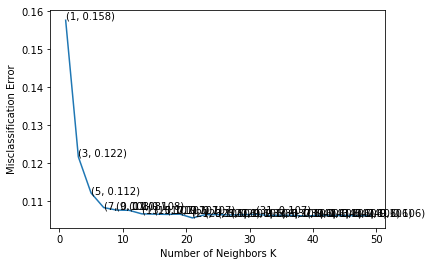

the misclassification error for each k value is :  [0.158 0.122 0.112 0.108 0.108 0.108 0.107 0.107 0.107 0.107 0.106 0.106
 0.106 0.106 0.106 0.107 0.106 0.106 0.106 0.106 0.106 0.106 0.106 0.106
 0.106]


In [49]:
from sklearn.model_selection import cross_val_score as cval_score
from sklearn.neighbors import KNeighborsClassifier

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn_brute = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cval_score(knn_brute, d_train,y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [50]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn_optimal.fit(d_train,y_train)
#for train error
y_true, y_pred = y_train, knn_optimal.predict(d_train)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("Train error is %.3f" %((fp+fn)/140))
#for test error
y_true, y_pred = y_test, knn_optimal.predict(d_test)
cm=confusion_matrix(y_true, y_pred)

Train error is 10.393



The value of TPR is 0.998
The value of TNR is 0.047
The value of FPR is 0.953
The value of FNR is 0.002

Test error is 10.733


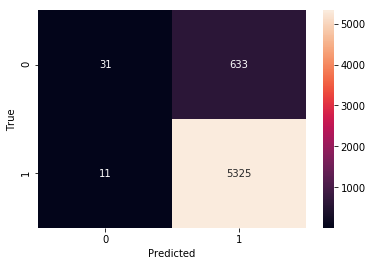

In [51]:
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='True')
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()
print("Test error is %.3f" %((fp+fn)/60))

## [18.4.7] KNN (KD-Tree)


The optimal number of neighbors is 21.


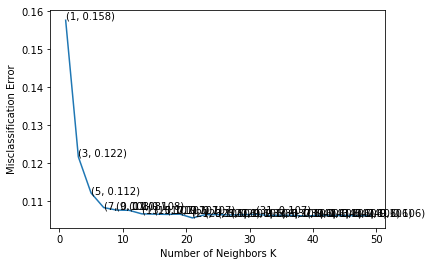

the misclassification error for each k value is :  [0.158 0.122 0.112 0.108 0.108 0.108 0.107 0.107 0.107 0.107 0.106 0.106
 0.106 0.106 0.106 0.107 0.106 0.106 0.106 0.106 0.106 0.106 0.106 0.106
 0.106]


In [52]:
from sklearn.model_selection import cross_val_score as cval_score
from sklearn.neighbors import KNeighborsClassifier

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn_brute = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cval_score(knn_brute, d_train,y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [53]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn_optimal.fit(d_train,y_train)
#for train error
y_true, y_pred = y_train, knn_optimal.predict(d_train)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("Train error is %.3f" %((fp+fn)/140))
#for test error
y_true, y_pred = y_test, knn_optimal.predict(d_test)
cm=confusion_matrix(y_true, y_pred)

Train error is 10.393



The value of TPR is 0.998
The value of TNR is 0.047
The value of FPR is 0.953
The value of FNR is 0.002

Test error is 10.733


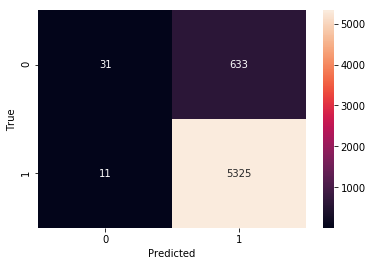

In [54]:
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='True')
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()
print("Test error is %.3f" %((fp+fn)/60))

## Conclusion ##

In [14]:
from prettytable import PrettyTable
    
pt = PrettyTable()

pt.field_names = [ "Model", "Vectorising Method", "Optimal K", "Train Error", "Test Error"]

pt.add_row(["KNN (Brute Force)","Bag Of Words", "11", "10.571", "11.000"])
pt.add_row(["KNN (Brute Force)","Bag Of Words with n-grams", "9","10.657","10.967"])
pt.add_row(["KNN (KD-Tree)","Bag Of Words", "7","10.036","10.967" ])
pt.add_row(["KNN (KD-Tree)","Bag Of Words with n-grams", "9", "9.736", "10.900" ])
pt.add_row(["KNN (Brute Force)","Tf-Idf", "7", "9.007" , "10.183"])
pt.add_row(["KNN (Brute Force)","Tf-Idf with n-grams", "7","8.857","10.283"])
pt.add_row(["KNN (KD-Tree)","Tf-Idf", "7","9.171","10.400"])
pt.add_row(["KNN (KD-Tree)","Tf-Idf with n-grams", "23","10.621","10.933" ])
pt.add_row(["KNN (Brute Force)","Avg W2V", "19" ,"10.143","10.783" ])
pt.add_row(["KNN (KD-Tree)","Avg W2V", "19" ,"10.143","10.783" ])
pt.add_row(["KNN (Brute Force)","Tf-Idf weighted W2V", "21", "10.393", "10.733"])
pt.add_row(["KNN (KD-Tree)","Tf-Idf weighted W2V", "21", "10.393", "10.733"])

print(pt)

+-------------------+---------------------------+-----------+-------------+------------+
|       Model       |     Vectorising Method    | Optimal K | Train Error | Test Error |
+-------------------+---------------------------+-----------+-------------+------------+
| KNN (Brute Force) |        Bag Of Words       |     11    |    10.571   |   11.000   |
| KNN (Brute Force) | Bag Of Words with n-grams |     9     |    10.657   |   10.967   |
|   KNN (KD-Tree)   |        Bag Of Words       |     7     |    10.036   |   10.967   |
|   KNN (KD-Tree)   | Bag Of Words with n-grams |     9     |    9.736    |   10.900   |
| KNN (Brute Force) |           Tf-Idf          |     7     |    9.007    |   10.183   |
| KNN (Brute Force) |    Tf-Idf with n-grams    |     7     |    8.857    |   10.283   |
|   KNN (KD-Tree)   |           Tf-Idf          |     7     |    9.171    |   10.400   |
|   KNN (KD-Tree)   |    Tf-Idf with n-grams    |     23    |    10.621   |   10.933   |
| KNN (Brute Force) |

1) Train error is almost same in all the cases.

2) Minimum train train error is achieved when we are vectorising with *tf-idf with uni-grams and bi-grams* and using *KNN with brute force* model.

3) Test error is also, almost same in all the cases.

4) We have achieved the minimum test error when we are vectorising with *tf-idf without un-igrams and bi-grams* and using *KNN with brute force* model.